# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import numpy as np

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 10, 12, 53, 143294)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# with open('../data/hopsworks-api-key.txt', 'r') as file:
#   os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159326
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [5]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

feature_view_lag = fs.get_feature_view(
    name='air_quality_fv_lag_3',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

retrieved_model_lag = mr.get_model(
    name="air_quality_xgboost_model_lag",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()
saved_model_dir_lag = retrieved_model_lag.download()

Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

retrieved_xgboost_model_lag = XGBRegressor()

retrieved_xgboost_model_lag.load_model(saved_model_dir_lag + "/model_lag.json")


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.date >= today).read()
weather_tomorrow = batch_data.iloc[[0]].reset_index(drop=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-20 00:00:00+00:00,5.10,0.1,17.610588,310.855286,vienna
1,2024-11-21 00:00:00+00:00,3.85,0.0,24.826952,286.858490,vienna
2,2024-11-22 00:00:00+00:00,3.55,0.0,26.987997,313.919159,vienna
3,2024-11-23 00:00:00+00:00,5.40,0.0,28.412645,292.340698,vienna
4,2024-11-24 00:00:00+00:00,6.25,0.0,10.245780,108.435043,vienna
5,2024-11-25 00:00:00+00:00,6.60,0.0,16.299694,133.210114,vienna
6,2024-11-26 00:00:00+00:00,5.65,0.0,14.007655,334.093536,vienna
7,2024-11-27 00:00:00+00:00,6.85,0.0,11.570515,354.644257,vienna


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data = batch_data.sort_values(by=['date'])
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 416.0+ bytes


In [10]:
air_quality_lag_fg = fs.get_feature_group(
    name='air_quality_with_rolling_window_3_days',
    version=1,
)

last_three_days = air_quality_lag_fg.filter(air_quality_lag_fg.date >= today - datetime.timedelta(days = 3)).read()

last_three_days

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 


,date,pm25,country,city,street,url,pm25_prev
0,2024-11-18 00:00:00+00:00,13.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860,37.333333
1,2024-11-17 00:00:00+00:00,57.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860,44.333333


In [11]:

weather_tomorrow

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-20 00:00:00+00:00,5.1,0.1,17.610588,310.855286,vienna


In [12]:
weather_tomorrow['pm25_prev'] = np.double(last_three_days['pm25'].mean())
weather_tomorrow

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_prev
0,2024-11-20 00:00:00+00:00,5.1,0.1,17.610588,310.855286,vienna,35.0


In [13]:
weather_tomorrow['predicted_pm25'] = retrieved_xgboost_model_lag.predict(
    weather_tomorrow[['pm25_prev','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
weather_tomorrow

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_prev,predicted_pm25
0,2024-11-20 00:00:00+00:00,5.1,0.1,17.610588,310.855286,vienna,35.0,42.953377


In [14]:
weather_tomorrow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         1 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          1 non-null      float32            
 2   precipitation_sum            1 non-null      float32            
 3   wind_speed_10m_max           1 non-null      float32            
 4   wind_direction_10m_dominant  1 non-null      float32            
 5   city                         1 non-null      object             
 6   pm25_prev                    1 non-null      float64            
 7   predicted_pm25               1 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(1), object(1)
memory usage: 172.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [15]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,5.10,0.1,17.610588,310.855286,vienna,56.285782,vienna-taborstraße-glockengasse,austria,1
1,2024-11-21 00:00:00+00:00,3.85,0.0,24.826952,286.858490,vienna,46.803688,vienna-taborstraße-glockengasse,austria,2
2,2024-11-22 00:00:00+00:00,3.55,0.0,26.987997,313.919159,vienna,45.171543,vienna-taborstraße-glockengasse,austria,3
3,2024-11-23 00:00:00+00:00,5.40,0.0,28.412645,292.340698,vienna,41.691452,vienna-taborstraße-glockengasse,austria,4
4,2024-11-24 00:00:00+00:00,6.25,0.0,10.245780,108.435043,vienna,105.261833,vienna-taborstraße-glockengasse,austria,5
5,2024-11-25 00:00:00+00:00,6.60,0.0,16.299694,133.210114,vienna,79.165169,vienna-taborstraße-glockengasse,austria,6
6,2024-11-26 00:00:00+00:00,5.65,0.0,14.007655,334.093536,vienna,76.711395,vienna-taborstraße-glockengasse,austria,7
7,2024-11-27 00:00:00+00:00,6.85,0.0,11.570515,354.644257,vienna,76.095787,vienna-taborstraße-glockengasse,austria,8


In [16]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float32            
 7   street                       8 non-null      object             
 8   country                      8 non-null      object             
 9   days_before_forecast_day     8 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), objec

In [17]:
weather_tomorrow['street'] = street
weather_tomorrow['city'] = city
weather_tomorrow['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
weather_tomorrow['days_before_forecast_day'] = 1
weather_tomorrow['date']=pd.to_datetime(weather_tomorrow['date'])
weather_tomorrow['date'] = weather_tomorrow['date'].dt.date
weather_tomorrow


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_prev,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20,5.1,0.1,17.610588,310.855286,vienna,35.0,42.953377,vienna-taborstraße-glockengasse,austria,1


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

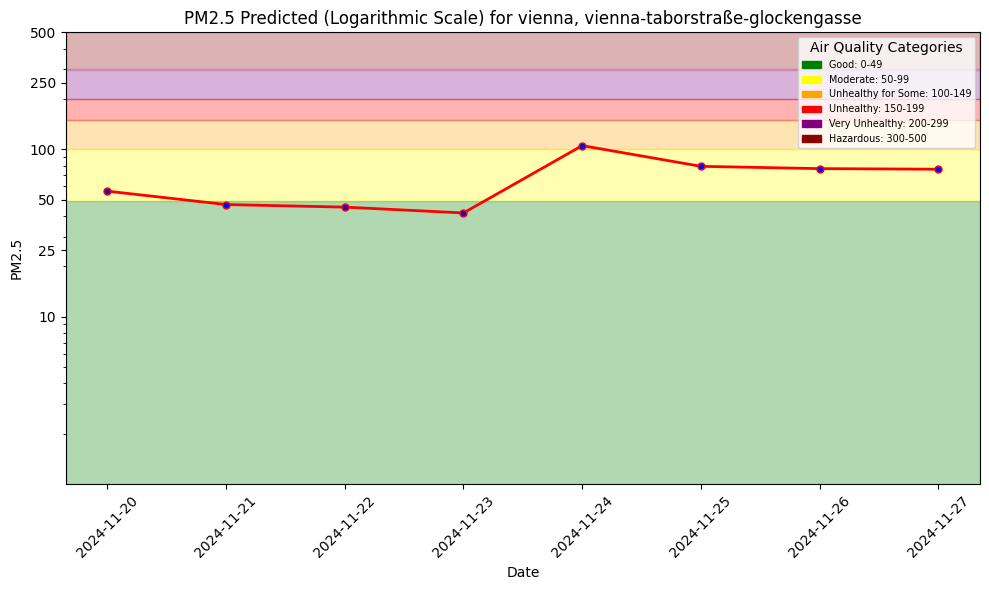

In [18]:
file_path = "../docs/air-quality/assets/img/pm25_forecast.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)

plt.show()

In [19]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [20]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159326/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2801a256c70>, None)

In [21]:
# Get or create feature group
monitor_lag_fg = fs.get_or_create_feature_group(
    name='aq_predictions_lag',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [22]:
monitor_lag_fg.insert(weather_tomorrow, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_lag_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159326/jobs/named/aq_predictions_lag_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2801a39bf70>, None)

In [24]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-15 00:00:00+00:00,9.10,0.0,21.758419,321.044067,vienna,74.792015,vienna-taborstraße-glockengasse,austria,1
1,2024-11-07 00:00:00+00:00,11.40,0.0,18.864824,131.905853,vienna,66.676254,vienna-taborstraße-glockengasse,austria,1
2,2024-11-12 00:00:00+00:00,5.75,0.0,12.303366,339.443878,vienna,96.964012,vienna-taborstraße-glockengasse,austria,1
3,2024-11-13 00:00:00+00:00,5.10,0.0,16.992609,323.615540,vienna,82.902176,vienna-taborstraße-glockengasse,austria,1
4,2024-11-14 00:00:00+00:00,7.20,0.0,19.171478,304.286926,vienna,48.696102,vienna-taborstraße-glockengasse,austria,1
5,2024-11-16 00:00:00+00:00,11.05,0.0,13.532360,151.389633,vienna,66.780052,vienna-taborstraße-glockengasse,austria,1
6,2024-11-17 00:00:00+00:00,8.30,0.0,8.311245,162.349792,vienna,89.230087,vienna-taborstraße-glockengasse,austria,1
7,2024-11-18 00:00:00+00:00,9.05,0.0,15.459054,297.758423,vienna,61.097874,vienna-taborstraße-glockengasse,austria,1
8,2024-11-19 00:00:00+00:00,7.25,0.0,10.739832,140.440369,vienna,66.656357,vienna-taborstraße-glockengasse,austria,1
9,2024-11-20 00:00:00+00:00,5.10,0.1,17.610588,310.855286,vienna,56.285782,vienna-taborstraße-glockengasse,austria,1


In [25]:
monitoring_lag_df = monitor_lag_fg.filter(monitor_lag_fg.days_before_forecast_day == 1).read()
monitoring_lag_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.57s) 


,pm25_prev,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,69.666667,2024-10-24,11.454499,0.2,20.025352,128.687881,vienna,75.581696,vienna-taborstraße-glockengasse,austria,1
1,37.333332,2024-11-19,7.400000,0.0,11.966954,136.218796,vienna,53.324047,vienna-taborstraße-glockengasse,austria,1
2,35.000000,2024-11-20,5.100000,0.1,17.610588,310.855286,vienna,42.953377,vienna-taborstraße-glockengasse,austria,1


In [29]:
monitoring_lag_df['date'] = pd.to_datetime(monitoring_lag_df['date'].astype(str)).dt.tz_localize('UTC')
monitoring_lag_df

,pm25_prev,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,69.666667,2024-10-24 00:00:00+00:00,11.454499,0.2,20.025352,128.687881,vienna,75.581696,vienna-taborstraße-glockengasse,austria,1
1,37.333332,2024-11-19 00:00:00+00:00,7.400000,0.0,11.966954,136.218796,vienna,53.324047,vienna-taborstraße-glockengasse,austria,1
2,35.000000,2024-11-20 00:00:00+00:00,5.100000,0.1,17.610588,310.855286,vienna,42.953377,vienna-taborstraße-glockengasse,austria,1


In [30]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,date,pm25,country,city,street,url
0,2015-01-19 00:00:00+00:00,93.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860
1,2016-02-12 00:00:00+00:00,55.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860
2,2017-11-06 00:00:00+00:00,33.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860
3,2023-03-22 00:00:00+00:00,45.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860
4,2016-10-15 00:00:00+00:00,64.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860
...,...,...,...,...,...,...
3932,2024-11-14 00:00:00+00:00,46.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860
3933,2024-11-15 00:00:00+00:00,34.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860
3934,2024-11-16 00:00:00+00:00,42.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860
3935,2024-11-17 00:00:00+00:00,57.0,austria,vienna,vienna-taborstraße-glockengasse,https://api.waqi.info/feed/@2860


In [31]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-07 00:00:00+00:00,66.676254,91.0
2,2024-11-12 00:00:00+00:00,96.964012,70.0
3,2024-11-13 00:00:00+00:00,82.902176,61.0
4,2024-11-14 00:00:00+00:00,48.696102,46.0
0,2024-11-15 00:00:00+00:00,74.792015,34.0
5,2024-11-16 00:00:00+00:00,66.780052,42.0
6,2024-11-17 00:00:00+00:00,89.230087,57.0
7,2024-11-18 00:00:00+00:00,61.097874,13.0


In [32]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_lag_df =  monitoring_lag_df[['date', 'predicted_pm25']]

hindcast_lag_df = pd.merge(preds_lag_df, outcome_df, on="date")
hindcast_lag_df = hindcast_lag_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_lag_df) == 0:
    hindcast_lag_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_lag_fg, retrieved_xgboost_model_lag)
hindcast_lag_df

,date,predicted_pm25,pm25
0,2024-10-24 00:00:00+00:00,75.581696,53.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

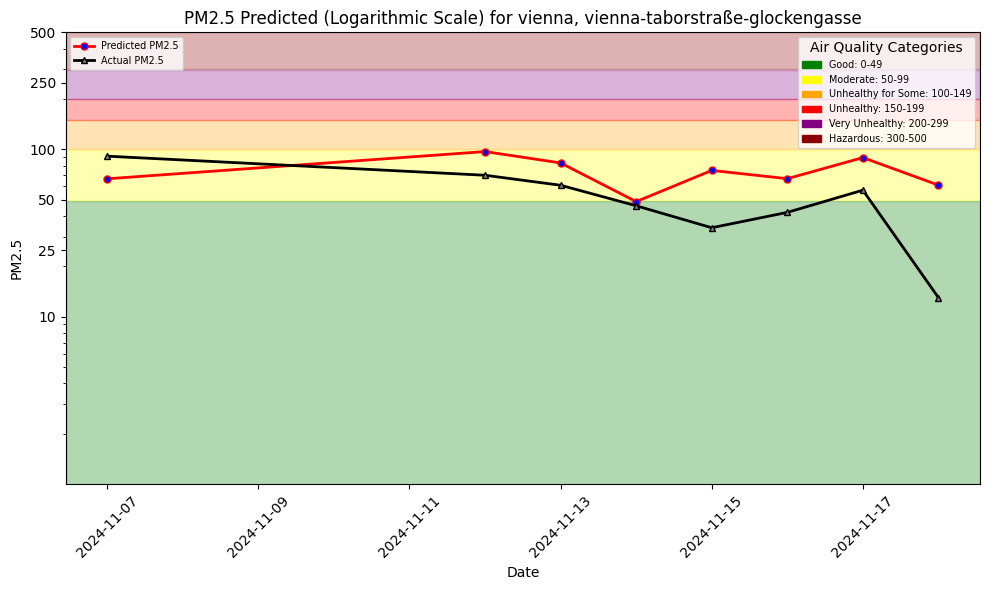

In [33]:
file_path = "../docs/air-quality/assets/img/pm25_hindcast_1day.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)

plt.show()

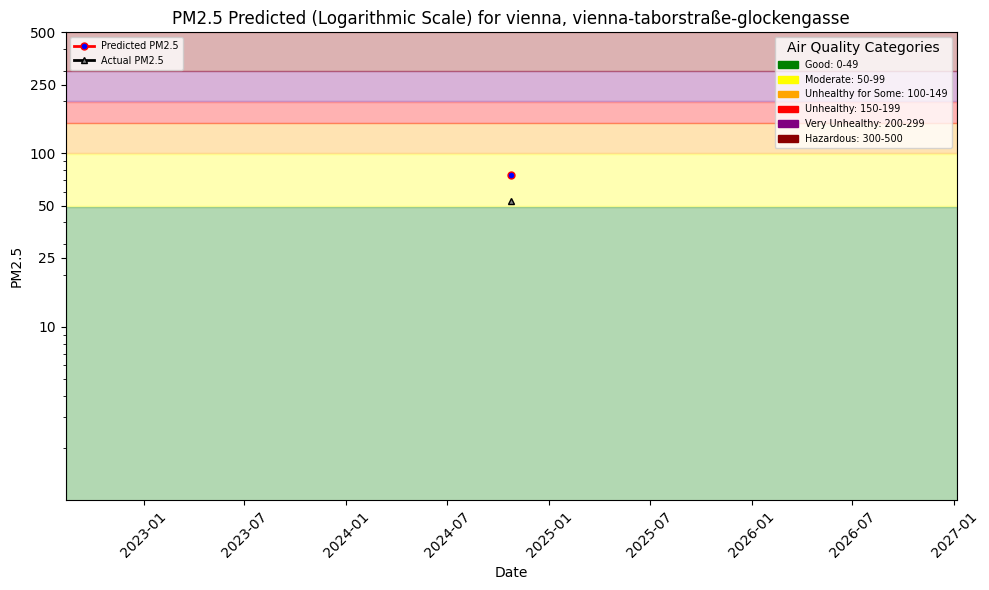

In [34]:
file_path = "../docs/air-quality/assets/img/pm25_hindcast_1day_lag.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_air_quality_forecast(city, street, hindcast_lag_df, file_path, hindcast=True)
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_air_quality_forecast(city, street, hindcast_lag_df, file_path, hindcast=True)

plt.show()

---